In [31]:
# DataFrame
import pandas as pd
from tqdm import tqdm_notebook, tnrange

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM,Input
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import LSTM, Dense, Embedding, Bidirectional,GlobalMaxPool1D
from keras.layers import TimeDistributed
from keras.optimizers import Adam,Nadam
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools


In [65]:
train=pd.read_csv('./data/train_E6oV3lV.csv')
test=pd.read_csv('./data/test_tweets_anuFYb8.csv')

In [66]:
train.head()
train=train.sample(frac=1)

In [67]:
combi = train.append(test, ignore_index=True,sort=False)

In [68]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        input_txt = input_txt.replace('&', ' and ')
        input_txt = input_txt.replace('@', ' at ')
        input_txt = input_txt.replace('0', ' zero ')
        input_txt = input_txt.replace('1', ' one ')
        input_txt = input_txt.replace('2', ' two ')
        input_txt = input_txt.replace('3', ' three ')
        input_txt = input_txt.replace('4', ' four ')
        input_txt = input_txt.replace('5', ' five ')
        input_txt = input_txt.replace('6', ' six ')
        input_txt = input_txt.replace('7', ' seven ')
        input_txt = input_txt.replace('8', ' eight ')
        input_txt = input_txt.replace('9', ' nine ')
        
    return input_txt    

In [69]:
# remove twitter handles (@user)
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")

In [70]:
# remove special characters, numbers, punctuations
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [71]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [72]:
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace('#',' Hashtag ')

In [82]:
combi.head()

,id,label,tweet,tidy_tweet
0,20221,0.0,my bihdayyyy face!!! :d #bihdaycake #candles...,bihdayyyy face Hashtag bihdaycake Hashtag ca...
1,14405,0.0,i'm taking this advice! !,taking this advice
2,8909,0.0,@user fred goldman family and nicole's loved o...,fred goldman family and nicole loved ones paid...
3,25755,0.0,love family ðâ¤ï¸ #handsome #brothers #lo...,love family Hashtag handsome Hashtag brother...
4,7832,0.0,@user at 10pm tonight #comedynightslive #super...,one zero tonight Hashtag comedynightslive Ha...


In [84]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: tknzr.tokenize(x)) 
# tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [bihdayyyy, face, Hashtag, bihdaycake, Hashtag...
1                               [taking, this, advice]
2    [fred, goldman, family, and, nicole, loved, on...
3    [love, family, Hashtag, handsome, Hashtag, bro...
4    [one, zero, tonight, Hashtag, comedynightslive...
Name: tidy_tweet, dtype: object

In [85]:
from nltk.stem.porter import *
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
stemmer = PorterStemmer()
lmtzr = WordNetLemmatizer()
tknzr = TweetTokenizer()


tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet = tokenized_tweet.apply(lambda x: [lmtzr.lemmatize(i) for i in x]) #lemmatize 

tokenized_tweet.head()

0    [bihdayyyi, face, hashtag, bihdaycak, hashtag,...
1                                   [take, thi, advic]
2    [fred, goldman, famili, and, nicol, love, one,...
3    [love, famili, hashtag, handsom, hashtag, brot...
4    [one, zero, tonight, hashtag, comedynightsl, h...
Name: tidy_tweet, dtype: object

In [86]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tidy_tweet'] = tokenized_tweet

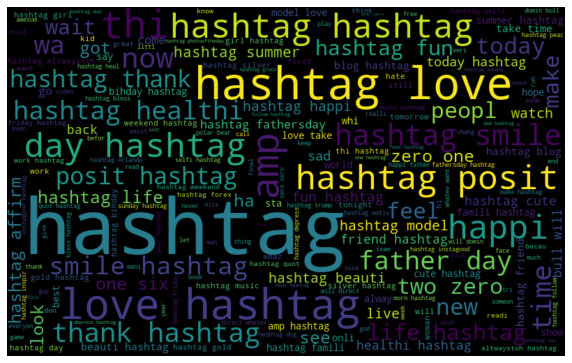

In [87]:
all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

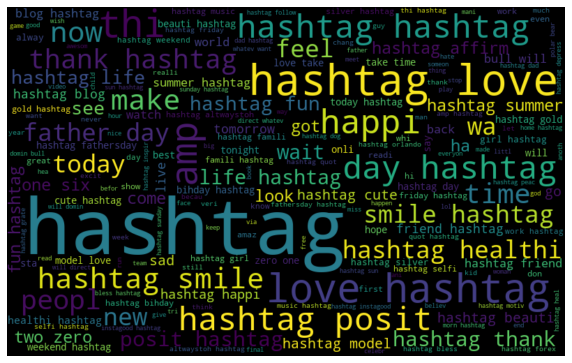

In [88]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

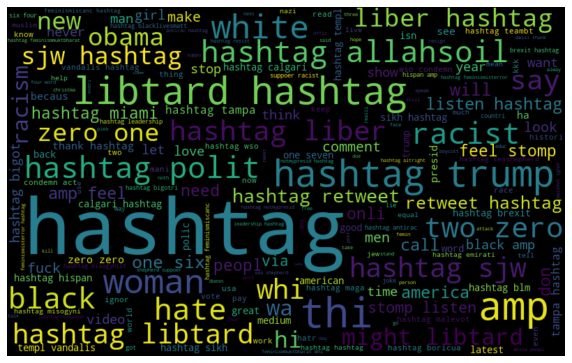

In [89]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [90]:
%%time
import gensim

from gensim.models import FastText , Word2Vec
documents = [_text.split() for _text in combi.tidy_tweet] 

CPU times: user 88.8 ms, sys: 4.98 ms, total: 93.7 ms
Wall time: 97.3 ms


In [91]:
# WORD2VEC 
W2V_SIZE = 200  #100
W2V_WINDOW = 5  #7
W2V_EPOCH = 50  #32
W2V_MIN_COUNT = 5  #5


In [92]:
model_fb = FastText(size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=16)
model_fb.build_vocab(documents)

2019-10-19 12:35:50,046 : INFO : resetting layer weights
2019-10-19 12:36:10,958 : INFO : collecting all words and their counts
2019-10-19 12:36:11,016 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-19 12:36:11,282 : INFO : PROGRESS: at sentence #10000, processed 124574 words, keeping 14833 word types
2019-10-19 12:36:11,353 : INFO : PROGRESS: at sentence #20000, processed 248151 words, keeping 23159 word types
2019-10-19 12:36:11,426 : INFO : PROGRESS: at sentence #30000, processed 372595 words, keeping 30021 word types
2019-10-19 12:36:11,484 : INFO : PROGRESS: at sentence #40000, processed 496303 words, keeping 36004 word types
2019-10-19 12:36:11,557 : INFO : collected 40953 word types from a corpus of 610073 raw words and 49159 sentences
2019-10-19 12:36:11,560 : INFO : Loading a fresh vocabulary
2019-10-19 12:36:11,614 : INFO : effective_min_count=5 retains 6824 unique words (16% of original 40953, drops 34129)
2019-10-19 12:36:11,615 : INFO : 

In [93]:
%%time
words = model_fb.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)
model_fb.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2019-10-19 12:36:24,062 : INFO : training model with 16 workers on 6824 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=5


Vocab size 6824


2019-10-19 12:36:25,160 : INFO : EPOCH 1 - PROGRESS: at 55.62% examples, 220078 words/s, in_qsize 28, out_qsize 0
2019-10-19 12:36:25,444 : INFO : worker thread finished; awaiting finish of 15 more threads
2019-10-19 12:36:25,448 : INFO : worker thread finished; awaiting finish of 14 more threads
2019-10-19 12:36:25,448 : INFO : worker thread finished; awaiting finish of 13 more threads
2019-10-19 12:36:25,457 : INFO : worker thread finished; awaiting finish of 12 more threads
2019-10-19 12:36:25,492 : INFO : worker thread finished; awaiting finish of 11 more threads
2019-10-19 12:36:25,495 : INFO : worker thread finished; awaiting finish of 10 more threads
2019-10-19 12:36:25,528 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-10-19 12:36:25,594 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-10-19 12:36:25,605 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-10-19 12:36:25,608 : INFO : worker thread finished; awai

2019-10-19 12:36:32,065 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-19 12:36:32,069 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-19 12:36:32,072 : INFO : EPOCH - 5 : training on 610073 raw words (402920 effective words) took 1.5s, 262266 effective words/s
2019-10-19 12:36:33,131 : INFO : EPOCH 6 - PROGRESS: at 40.98% examples, 158731 words/s, in_qsize 32, out_qsize 0
2019-10-19 12:36:33,711 : INFO : worker thread finished; awaiting finish of 15 more threads
2019-10-19 12:36:33,713 : INFO : worker thread finished; awaiting finish of 14 more threads
2019-10-19 12:36:33,715 : INFO : worker thread finished; awaiting finish of 13 more threads
2019-10-19 12:36:33,726 : INFO : worker thread finished; awaiting finish of 12 more threads
2019-10-19 12:36:33,737 : INFO : worker thread finished; awaiting finish of 11 more threads
2019-10-19 12:36:33,756 : INFO : worker thread finished; awaiting finish of 10 more threads
2019-10-19 12:36:

2019-10-19 12:36:40,131 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-10-19 12:36:40,134 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-19 12:36:40,135 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-19 12:36:40,140 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-19 12:36:40,143 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-19 12:36:40,144 : INFO : EPOCH - 10 : training on 610073 raw words (403052 effective words) took 1.5s, 266126 effective words/s
2019-10-19 12:36:41,200 : INFO : EPOCH 11 - PROGRESS: at 65.49% examples, 254456 words/s, in_qsize 22, out_qsize 0
2019-10-19 12:36:41,434 : INFO : worker thread finished; awaiting finish of 15 more threads
2019-10-19 12:36:41,435 : INFO : worker thread finished; awaiting finish of 14 more threads
2019-10-19 12:36:41,436 : INFO : worker thread finished; awaiting finish of 13 more threads
2019-10-19 12:36:4

2019-10-19 12:36:48,682 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-10-19 12:36:48,713 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-10-19 12:36:48,723 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-10-19 12:36:48,733 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-10-19 12:36:48,740 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-10-19 12:36:48,751 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-19 12:36:48,759 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-19 12:36:48,764 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-19 12:36:48,769 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-19 12:36:48,770 : INFO : EPOCH - 15 : training on 610073 raw words (402702 effective words) took 2.1s, 190141 effective words/s
2019-10-19 12:36:49,810 : INFO : EPOCH 16 - P

2019-10-19 12:36:57,197 : INFO : worker thread finished; awaiting finish of 12 more threads
2019-10-19 12:36:57,280 : INFO : worker thread finished; awaiting finish of 11 more threads
2019-10-19 12:36:57,290 : INFO : worker thread finished; awaiting finish of 10 more threads
2019-10-19 12:36:57,307 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-10-19 12:36:57,334 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-10-19 12:36:57,348 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-10-19 12:36:57,355 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-10-19 12:36:57,373 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-10-19 12:36:57,376 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-10-19 12:36:57,378 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-19 12:36:57,385 : INFO : worker thread finished; awaiting finish of 2 more thre

2019-10-19 12:37:05,539 : INFO : worker thread finished; awaiting finish of 15 more threads
2019-10-19 12:37:05,540 : INFO : worker thread finished; awaiting finish of 14 more threads
2019-10-19 12:37:05,549 : INFO : worker thread finished; awaiting finish of 13 more threads
2019-10-19 12:37:05,560 : INFO : worker thread finished; awaiting finish of 12 more threads
2019-10-19 12:37:05,624 : INFO : worker thread finished; awaiting finish of 11 more threads
2019-10-19 12:37:05,660 : INFO : worker thread finished; awaiting finish of 10 more threads
2019-10-19 12:37:05,664 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-10-19 12:37:05,676 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-10-19 12:37:05,680 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-10-19 12:37:05,687 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-10-19 12:37:05,717 : INFO : worker thread finished; awaiting finish of 5 more t

2019-10-19 12:37:13,160 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-19 12:37:13,170 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-19 12:37:13,170 : INFO : EPOCH - 29 : training on 610073 raw words (402525 effective words) took 2.0s, 197571 effective words/s
2019-10-19 12:37:14,188 : INFO : EPOCH 30 - PROGRESS: at 39.28% examples, 158002 words/s, in_qsize 27, out_qsize 4
2019-10-19 12:37:14,644 : INFO : worker thread finished; awaiting finish of 15 more threads
2019-10-19 12:37:14,645 : INFO : worker thread finished; awaiting finish of 14 more threads
2019-10-19 12:37:14,688 : INFO : worker thread finished; awaiting finish of 13 more threads
2019-10-19 12:37:14,689 : INFO : worker thread finished; awaiting finish of 12 more threads
2019-10-19 12:37:14,706 : INFO : worker thread finished; awaiting finish of 11 more threads
2019-10-19 12:37:14,745 : INFO : worker thread finished; awaiting finish of 10 more threads
2019-10-19 12:3

2019-10-19 12:37:21,421 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-10-19 12:37:21,422 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-10-19 12:37:21,423 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-19 12:37:21,424 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-19 12:37:21,435 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-19 12:37:21,447 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-19 12:37:21,448 : INFO : EPOCH - 34 : training on 610073 raw words (402918 effective words) took 1.5s, 274653 effective words/s
2019-10-19 12:37:22,559 : INFO : EPOCH 35 - PROGRESS: at 47.50% examples, 178567 words/s, in_qsize 31, out_qsize 1
2019-10-19 12:37:22,920 : INFO : worker thread finished; awaiting finish of 15 more threads
2019-10-19 12:37:22,929 : INFO : worker thread finished; awaiting finish of 14 more threads
2019-10-19 12:37:22

2019-10-19 12:37:29,661 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-10-19 12:37:29,668 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-10-19 12:37:29,759 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-10-19 12:37:29,762 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-10-19 12:37:29,773 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-10-19 12:37:29,777 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-10-19 12:37:29,786 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-19 12:37:29,787 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-19 12:37:29,788 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-19 12:37:29,788 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-19 12:37:29,789 : INFO : EPOCH - 39 : training on 610073 raw words (402757 effecti

2019-10-19 12:37:37,128 : INFO : worker thread finished; awaiting finish of 13 more threads
2019-10-19 12:37:37,132 : INFO : worker thread finished; awaiting finish of 12 more threads
2019-10-19 12:37:37,254 : INFO : worker thread finished; awaiting finish of 11 more threads
2019-10-19 12:37:37,255 : INFO : worker thread finished; awaiting finish of 10 more threads
2019-10-19 12:37:37,256 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-10-19 12:37:37,260 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-10-19 12:37:37,264 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-10-19 12:37:37,268 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-10-19 12:37:37,297 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-10-19 12:37:37,306 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-10-19 12:37:37,312 : INFO : worker thread finished; awaiting finish of 3 more thr

2019-10-19 12:37:44,042 : INFO : EPOCH 49 - PROGRESS: at 60.57% examples, 236712 words/s, in_qsize 25, out_qsize 0
2019-10-19 12:37:44,233 : INFO : worker thread finished; awaiting finish of 15 more threads
2019-10-19 12:37:44,236 : INFO : worker thread finished; awaiting finish of 14 more threads
2019-10-19 12:37:44,237 : INFO : worker thread finished; awaiting finish of 13 more threads
2019-10-19 12:37:44,240 : INFO : worker thread finished; awaiting finish of 12 more threads
2019-10-19 12:37:44,240 : INFO : worker thread finished; awaiting finish of 11 more threads
2019-10-19 12:37:44,259 : INFO : worker thread finished; awaiting finish of 10 more threads
2019-10-19 12:37:44,282 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-10-19 12:37:44,310 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-10-19 12:37:44,325 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-10-19 12:37:44,333 : INFO : worker thread finished; awa

CPU times: user 4min 20s, sys: 2.4 s, total: 4min 23s
Wall time: 1min 22s


In [54]:
# fasttext_model = 'fasttext.model'
# model_fb.save(fasttext_model)
# print('FastText Model saved at {}'.format(fasttext_model))

In [55]:
## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [194]:
df_train=combi[:len(train)]
df_test=combi[len(train):]

In [195]:
df_train.shape ,df_test.shape

((31962, 4), (17197, 4))

In [196]:
df_train.head()

,id,label,tweet,tidy_tweet
0,20221,0.0,my bihdayyyy face!!! :d #bihdaycake #candles...,bihdayyyi face hashtag bihdaycak hashtag candl...
1,14405,0.0,i'm taking this advice! !,take thi advic
2,8909,0.0,@user fred goldman family and nicole's loved o...,fred goldman famili and nicol love one paid th...
3,25755,0.0,love family ðâ¤ï¸ #handsome #brothers #lo...,love famili hashtag handsom hashtag brother ha...
4,7832,0.0,@user at 10pm tonight #comedynightslive #super...,one zero tonight hashtag comedynightsl hashtag...


In [197]:
df_train.label.value_counts()

0.0    29720
1.0     2242
Name: label, dtype: int64

In [198]:
df_test.drop('label',1,inplace=True)

In [199]:
df_test.head()

,id,tweet,tidy_tweet
31962,31963,#studiolife #aislife #requires #passion #dedic...,hashtag studiolif hashtag aislif hashtag requi...
31963,31964,@user #white #supremacists want everyone to s...,hashtag white hashtag supremacist want everyon...
31964,31965,safe ways to heal your #acne!! #altwaystohe...,safe way heal your hashtag acn hashtag altways...
31965,31966,is the hp and the cursed child book up for res...,the and the cur child book for reserv alreadi ...
31966,31967,"3rd #bihday to my amazing, hilarious #nephew...",hashtag bihday amaz hilari hashtag nephew eli ...


In [110]:
embed_dim = 200 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_seq_len = 100 # max number of words in a question to use

In [111]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(combi.tidy_tweet)
word_index = tokenizer.word_index
word_seq_train = tokenizer.texts_to_sequences(df_train['tidy_tweet'])
word_seq_test = tokenizer.texts_to_sequences(df_test['tidy_tweet'])
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = pad_sequences(word_seq_test, maxlen=max_seq_len)

dictionary size:  40953


In [112]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())
y_train = encoder.transform(df_train.label.tolist())
y_train = y_train.reshape(-1,1)
print("y_train",y_train.shape)

y_train (31962, 1)


In [114]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fb.wv.get_vector(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [156]:
embedding_layer = Embedding(nb_words, embed_size, weights=[embedding_matrix], input_length=max_seq_len, trainable=False)

In [157]:
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2,return_sequences=True)))
model.add(TimeDistributed(Dense(128, use_bias=True)))
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 200)          8190600   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 512)          935936    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 100, 128)          65664     
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               1280100   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [158]:
from keras import backend as K
import tensorflow as tf
model.compile(optimizer='adam',metrics=['accuracy'],loss='binary_crossentropy')

In [159]:
callbacks = [ReduceLROnPlateau(monitor='val_accuracy', patience=5, cooldown=0,verbose=1,factor=0.5),
            TensorBoard(log_dir='./Graph', write_graph=True, write_images=True),
            ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,mode='max'),
           EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)]

In [160]:
%%time
history = model.fit(word_seq_train, y_train,
                    batch_size=128,
                    epochs=50,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=callbacks)

Train on 25569 samples, validate on 6393 samples
Epoch 1/50
25569/25569 [==============================] - 227s 9ms/step - loss: 0.1594 - accuracy: 0.9434 - val_loss: 0.1354 - val_accuracy: 0.9526

Epoch 00001: saving model to ModelCheckpoint/Bi_LSTM_Ensemble.01-0.953.hdf5
Epoch 2/50
25569/25569 [==============================] - 226s 9ms/step - loss: 0.1202 - accuracy: 0.9572 - val_loss: 0.1211 - val_accuracy: 0.9528

Epoch 00002: saving model to ModelCheckpoint/Bi_LSTM_Ensemble.02-0.953.hdf5
Epoch 3/50
25569/25569 [==============================] - 276s 11ms/step - loss: 0.1005 - accuracy: 0.9618 - val_loss: 0.1189 - val_accuracy: 0.9593

Epoch 00003: saving model to ModelCheckpoint/Bi_LSTM_Ensemble.03-0.959.hdf5
Epoch 4/50
25569/25569 [==============================] - 290s 11ms/step - loss: 0.0816 - accuracy: 0.9684 - val_loss: 0.1185 - val_accuracy: 0.9625

Epoch 00004: saving model to ModelCheckpoint/Bi_LSTM_Ensemble.04-0.962.hdf5
Epoch 5/50
25569/25569 [=========================

In [201]:
len(word_seq_train), len(word_seq_test) , len(df_test.id)

(31962, 17197, 17197)

In [202]:
pred=model.predict(word_seq_test)

InvalidArgumentError:  indices[12,95] = 40953 is not in [0, 40953)
	 [[node embedding_3/embedding_lookup (defined at /Users/subir/pythonenv/default/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_keras_scratch_graph_70626]

Function call stack:
keras_scratch_graph


In [111]:
new_test.drop('tweet',1,inplace=True)

In [112]:
new_test.drop('tidy_tweet',1,inplace=True)

In [113]:
new_test.to_csv('new_sub1.csv',index=False)